In [1]:
import harmonica as hm
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import skimage.exposure
import verde as vd
import xarray as xr

import magali as mg

In [2]:
sensor_sample_distance = 5.0  # µm
region = [0, 2000, 0, 2000]  # µm
spacing = 2  # µm

true_inclination = 30
true_declination = 40
true_dispersion_angle = 5

size = 100

directions_inclination, directions_declination = mg.random_directions(
    true_inclination,
    true_declination,
    true_dispersion_angle,
    size=size,
    random_state=5,
)

dipoles_amplitude = abs(np.random.normal(0, 100, size)) * 1.0e-14

dipole_coordinates = (
    np.concatenate([np.random.randint(30, 1970, size), [1250, 1300, 500]]),  # µm
    np.concatenate([np.random.randint(30, 1970, size), [500, 1750, 1000]]),  # µm
    np.concatenate([np.random.randint(-20, -1, size), [-15, -15, -30]]),  # µm
)
dipole_moments = hm.magnetic_angles_to_vec(
    inclination=np.concatenate([directions_inclination, [10, -10, -5]]),
    declination=np.concatenate([directions_declination, [10, 170, 190]]),
    intensity=np.concatenate([dipoles_amplitude, [5e-11, 5e-11, 5e-11]]),
)

data = mg.dipole_bz_grid(
    region, spacing, sensor_sample_distance, dipole_coordinates, dipole_moments
)

data_tga = mg.total_gradient_amplitude_grid(data)
data

/home/yago/miniforge3/envs/magali/lib/python3.12/site-packages/xrft/xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
/home/yago/miniforge3/envs/magali/lib/python3.12/site-packages/xrft/xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)


<xarray.DataArray 'bz' (y: 1001, x: 1001)> Size: 8MB
array([[ 5.86762813,  5.92520283,  5.98360279, ..., 13.09524784,
        12.98794724, 12.88144482],
       [ 5.91006   ,  5.96841026,  6.02760421, ..., 13.24921479,
        13.14002325, 13.03164597],
       [ 5.9527739 ,  6.0119091 ,  6.07190679, ..., 13.40592959,
        13.29479985, 13.184501  ],
       ...,
       [ 2.93957101,  2.96731154,  2.99541016, ..., 51.46955032,
        49.19183522, 47.0471341 ],
       [ 2.9160677 ,  2.94331772,  2.97091394, ..., 50.45431856,
        48.25296539, 46.17785942],
       [ 2.89284229,  2.91961383,  2.94672019, ..., 49.42907798,
        47.30384392, 45.29822314]])
Coordinates:
  * x        (x) float64 8kB 0.0 2.0 4.0 6.0 ... 1.996e+03 1.998e+03 2e+03
  * y        (y) float64 8kB 0.0 2.0 4.0 6.0 ... 1.996e+03 1.998e+03 2e+03
    z        (y, x) float64 8MB 5.0 5.0 5.0 5.0 5.0 5.0 ... 5.0 5.0 5.0 5.0 5.0
Attributes:
    long_name:  vertical magnetic field
    units:      nT

In [3]:
stretched = skimage.exposure.rescale_intensity(
    data_tga,
    in_range=tuple(np.percentile(data_tga, (1, 99))),
)
data_tga_stretched = xr.DataArray(stretched, coords=data_tga.coords)
data_tga_stretched

<xarray.DataArray (y: 1001, x: 1001)> Size: 8MB
array([[4.69130960e-05, 2.64455848e-04, 1.78369911e-04, ...,
        1.14333198e-02, 1.03509504e-02, 1.01630965e-02],
       [4.09093385e-03, 1.41029831e-04, 1.27676749e-03, ...,
        2.60748739e-03, 1.33279241e-03, 5.05968677e-03],
       [2.36253727e-03, 3.84505291e-07, 6.66707757e-04, ...,
        2.05600318e-03, 2.61875337e-03, 1.92851569e-04],
       ...,
       [1.44705004e-02, 2.39398470e-03, 3.19573741e-03, ...,
        4.59596078e-03, 1.20952563e-03, 1.51214165e-02],
       [1.24784967e-02, 2.46670094e-03, 2.53929723e-03, ...,
        4.65129778e-04, 5.10622807e-03, 9.54357293e-03],
       [1.63923901e-02, 2.47709898e-03, 4.03307513e-03, ...,
        1.35486312e-02, 6.42063394e-03, 2.42684423e-02]])
Coordinates:
  * x        (x) float64 8kB 0.0 2.0 4.0 6.0 ... 1.996e+03 1.998e+03 2e+03
  * y        (y) float64 8kB 0.0 2.0 4.0 6.0 ... 1.996e+03 1.998e+03 2e+03
    z        (y, x) float64 8MB 5.0 5.0 5.0 5.0 5.0 5.0 ... 5.0 5.0 5.0 5.0 5.0

### Stretch the contrast of TGA

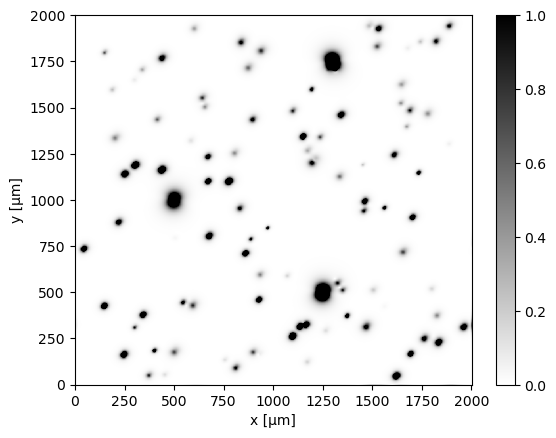

In [4]:
data_tga_stretched.plot.pcolormesh(cmap="gray_r")

## Detection

In [5]:
size_range = [25, 50]
size_increment = 1.0
threshold = 0.01
overlap = 0.3
exclude_border = 1
num_scales = 5
border_exclusion = 0
overlap_ratio = 0.3

In [6]:
def _calculate_blob_sizes(detected_scales, grid_spacing, size_multiplier):
    """
    Calculate the sizes of the blobs in μm.

    Parameters
    ----------
    detected_scales : array-like
        Detected blob scales (sigma values).
    grid_spacing : float
        Grid spacing between data points.
    size_multiplier : int
        Scaling factor for the detected blob sizes.

    Returns
    -------
    array-like
        Calculated sizes of the blobs in data units.
    """
    return detected_scales * np.sqrt(2) * grid_spacing * size_multiplier

In [7]:
def _generate_bounding_boxes(blob_sizes, blob_x_coords, blob_y_coords):
    """
    Generate bounding boxes around detected blobs based on their sizes and coordinates.

    Parameters
    ----------
    blob_sizes : array-like
        Sizes of the detected blobs.
    blob_x_coords : array-like
        X coordinates of the detected blobs.
    blob_y_coords : array-like
        Y coordinates of the detected blobs.

    Returns
    -------
    list of lists
        Bounding boxes in data coordinates for each detected blob.
    """
    return [
        [x - size, x + size, y - size, y + size]
        for size, x, y in zip(blob_sizes, blob_x_coords, blob_y_coords)
    ]

In [8]:
def detect_anomalies(
    data,
    size_range,
    size_multiplier=2,
    num_scales=10,
    detection_threshold=0.5,
    overlap_ratio=0.5,
    border_exclusion=0,
):
    """
    Detect anomalies using blob detection and produce bounding boxes in data coordinates.

    Parameters
    ----------
    data : xr.DataArray
        Input data array with coordinates "x" and "y".
    size_range : tuple
        Minimum and maximum size of detected anomalies in data units.
    size_multiplier : int, optional
        Scaling factor for the detected blob sizes (default is 2).
    num_scales : int, optional
        Number of sigma values for the blob detection (default is 10). A sigma value represents
        the scale or size of the blobs that the algorithm will detect. Smaller sigma values correspond
        to smaller blobs, while larger sigma values correspond to larger blobs.
    detection_threshold : float, optional
        Detection threshold for the blob detection (default is 0.5). This parameter determines the sensitivity
        of the detection. A higher value means fewer blobs will be detected, and a lower value means more blobs
        will be detected.
    overlap_ratio : float, optional
        Overlap fraction for merging blobs (default is 0.5).
    border_exclusion : int, optional
        Border exclusion size in data units (default is 0). This parameter excludes blobs close to the border of
        the data array.

    Returns
    -------
    bounding_boxes : list of lists
        Bounding boxes of detected anomalies in data coordinates. Each bounding box corresponds to a detected blob,
        defined by the coordinates and size of the blob.
    """
    grid_spacing = mg._utils._estimate_grid_spacing(data)
    min_sigma, max_sigma = [0.5 * size for size in size_range]

    y_indices, x_indices, detected_scales = skimage.feature.blob_log(
        data_tga_stretched,
        min_sigma=min_sigma,
        max_sigma=max_sigma,
        threshold=detection_threshold,
        num_sigma=num_scales,
        overlap=overlap_ratio,
        exclude_border=border_exclusion,
    ).T  # Transpose the output to separate y, x, and scale values

    blob_x_coords = data.x.values[x_indices.astype(int)]
    blob_y_coords = data.y.values[y_indices.astype(int)]

    blob_sizes = _calculate_blob_sizes(detected_scales, grid_spacing, size_multiplier)
    bounding_boxes = _generate_bounding_boxes(blob_sizes, blob_x_coords, blob_y_coords)
    return bounding_boxes

In [17]:
windows = detect_anomalies(
    data,
    size_range,
    size_multiplier=2,
    num_scales=10,
    detection_threshold=0.01,
    overlap_ratio=0.5,
    border_exclusion=1,
)

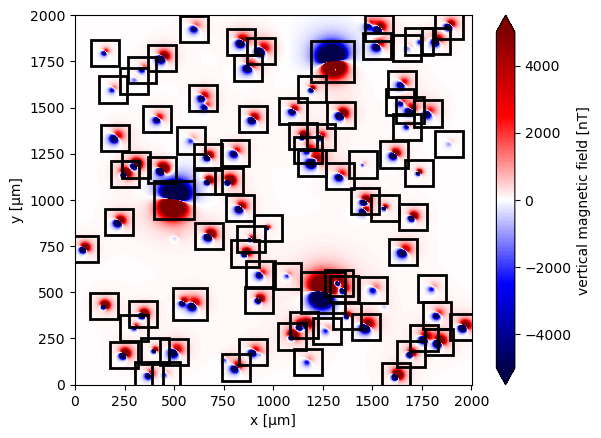

In [18]:
ax = plt.subplot(111)
data.plot.pcolormesh(ax=ax, cmap="seismic", vmin=-5000, vmax=5000)
for window in windows:
    rect = matplotlib.patches.Rectangle(
        xy=[window[0], window[2]],
        width=window[1] - window[0],
        height=window[3] - window[2],
        edgecolor="k",
        fill=False,
        linewidth=2,
    )
    ax.add_patch(rect)